In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jupyter_black

jupyter_black.load()

In [3]:
import os
import multiprocessing

# Disable CUDA because only one gpu device allows only a single chain
os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count={}".format(
    multiprocessing.cpu_count()
)
import jax

jax.default_backend()
jax.devices()

2023-07-29 10:19:32.395611: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


[CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3)]

In [4]:
from yomi_skill.model import YomiModel, weight_by
from yomi_skill.models import *
from yomi_skill.models.mu_glicko import *
from yomi_skill.yomi import historical_record
import pandas
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import tempfile

from sklearn.calibration import CalibrationDisplay
from sklearn.model_selection import train_test_split, cross_validate

In [5]:
fit_dir = tempfile.mkdtemp()

# Set up games

In [6]:
tournament_games = historical_record.latest_tournament_games()
sirlin_games = historical_record.sirlin_db()
games = pandas.concat([tournament_games, sirlin_games]).reset_index(drop=True)

games = games

In [7]:
games = historical_record.augment_dataset(games)

Constructing PC category


# Set up models

In [8]:
min_games = 0
warmup = 500
samples = 1000

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    games,
    games.win.astype("int"),
)

In [10]:
MODELS = {
    model.model_name: model
    for model_type in YomiModel.__subclasses__()
    for model in model_type.__subclasses__()
}

In [11]:
MODELS

{'mu_pc_glicko': yomi_skill.models.mu_pc_glicko.MUPCGlicko,
 'pc_elo': yomi_skill.models.pc_elo.PCElo,
 'mu_pc_elo_c': yomi_skill.models.mu_pc_elo_c.MUPCEloC,
 'char_skill_skelo_skill_deficit': yomi_skill.models.char_skill_skelo_skill_deficit.CharSkillSkeloSkillDeficit,
 'mu': yomi_skill.models.mu_only.MUOnly,
 'glicko': yomi_skill.models.glicko.Glicko,
 'elo': yomi_skill.models.elo.Elo,
 'mu_pc_elo_vol': yomi_skill.models.mu_pc_elo_vol.MUPCEloVol,
 'char_skill_glicko_skill_deficit': yomi_skill.models.char_skill_glicko_skill_deficit.CharSkillGlickoSkillDeficit,
 'mu_pc_elo': yomi_skill.models.mu_pc_elo.MUPCElo,
 'full_glicko': yomi_skill.models.full_glicko.FullGlicko,
 'custom_glicko': yomi_skill.models.custom_glicko.CustomGlicko,
 'full': yomi_skill.models.full.Full,
 'mu_elo': yomi_skill.models.mu_elo.MUElo,
 'mu_glicko': yomi_skill.models.mu_glicko.MUGlicko,
 'pc_glicko': yomi_skill.models.pc_glicko_only.PCGlicko}

In [19]:
model_names = [
    "full",
    "full_glicko",
    # "custom_glicko",
    # 'mu',
    # 'elo',
    # 'mu_elo',
    # 'pc_elo',
    # 'mu_pc_elo',
    # 'mu_pc_elo_vol',
    # 'mu_pc_elo_c',
    # 'glicko',
    # 'mu_glicko',
    # 'pc_glicko',
    # 'mu_pc_glicko',
]
models = {
    model_name: MODELS[model_name](min_games=min_games, warmup=warmup, samples=samples)
    for model_name in model_names
}

In [36]:
parameters = {}
parameters["full"] = dict(
    transform__elo__initial_time=games.match_date.min(),
    transform__pc_elo__initial_time=games.match_date.min(),
    model__min_games=min_games,
    model__warmup=warmup,
    model__samples=samples,
    transform__elo__default_k=16,
    transform__pc_elo__default_k=1,
)

parameters["full_glicko"] = dict(
    transform__glicko__initial_time=games.match_date.min(),
    transform__pc_glicko__initial_time=games.match_date.min(),
    model__min_games=min_games,
    model__warmup=warmup,
    model__samples=samples,
    transform__glicko__initial_value=(1500.0, 30, 0.09),
    transform__pc_glicko__initial_value=(1500.0, 50, 0.007),
)
parameters["custom_glicko"] = dict(
    transform__glicko__initial_time=games.match_date.min(),
    transform__pc_glicko__initial_time=games.match_date.min(),
    model__min_games=min_games,
    model__warmup=warmup,
    model__samples=samples,
    # transform__glicko__initial_value=(1500.0, 30, 0.09),
    # transform__pc_glicko__initial_value=(1500.0, 50, 0.007),
)
parameters["mu_elo"] = dict(
    transform__elo__initial_time=games.match_date.min(),
    model__min_games=min_games,
    model__warmup=warmup,
    model__samples=samples,
)
parameters["mu_pc_elo"] = dict(
    transform__pc_elo__initial_time=games.match_date.min(),
    model__min_games=min_games,
    model__warmup=warmup,
    model__samples=samples,
)

In [40]:
pipelines = {
    model_name: models[model_name].pipeline(**parameters[model_name])
    for model_name in models
}

# Fit Models

In [41]:
from sklearn import set_config

set_config(transform_output="pandas")

In [42]:
for model_name in pipelines:
    if not hasattr(pipelines[model_name]["model"], "inf_data_"):
        pipelines[model_name].fit(
            X_train,
            y_train,
            # sample_weight=X_train[f'{models[model_name].weight_key}_weight']
        )

Compiling...
Compilation time =  0:00:01.245336
Sampling...
Sampling time =  0:00:05.334466
Transforming variables...
Transformation time =  0:03:32.358850
Compiling...
Compilation time =  0:00:03.318888
Sampling...
Sampling time =  0:00:07.022812
Transforming variables...
Transformation time =  0:03:39.147807


# Render matchup data

In [ ]:
from yomi_skill.render import *
render = YomiRender(pipelines['full2'])
display(pipelines['full2']['model'].data_)
filename = render.render_matchup_comparator('src-site/src/data/yomi')
print(filename)


# Validate models

In [43]:
pred_test = {
    model_name: pipelines[model_name].predict_proba(X_test)[:, 1]
    for model_name in pipelines
    if hasattr(pipelines[model_name]["model"], "inf_data_")
}

In [44]:
df_pred_test = pandas.DataFrame(pred_test)

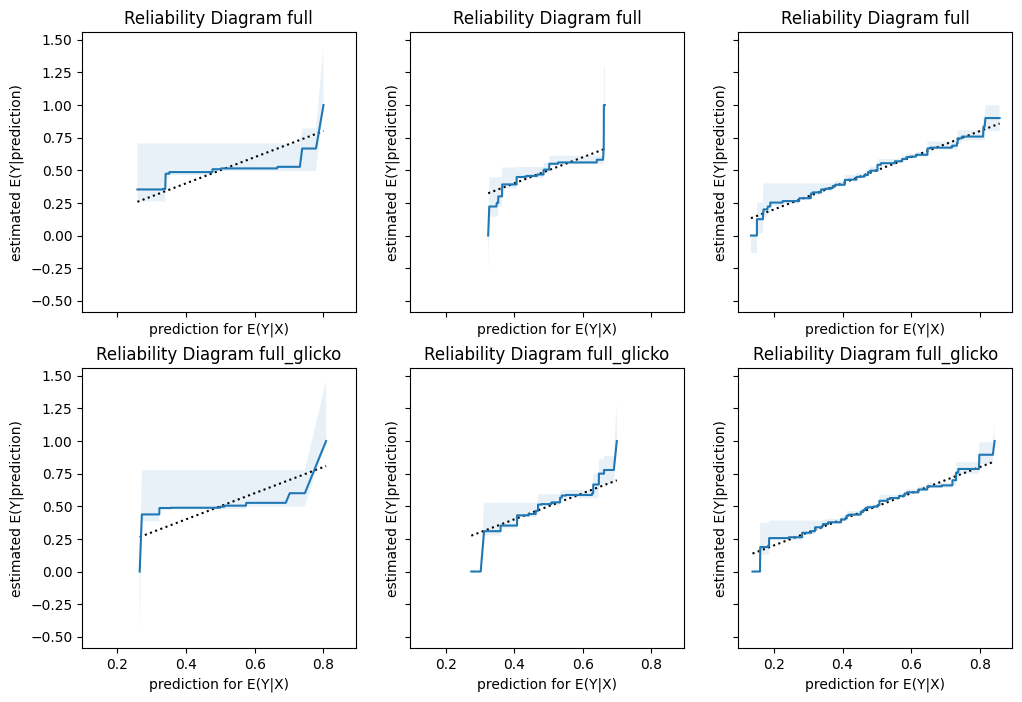

In [45]:
import matplotlib.pyplot as plt
from model_diagnostics.calibration import (
    compute_bias,
    plot_bias,
    plot_reliability_diagram,
)

fig, axes = plt.subplots(
    ncols=3,
    nrows=len(pred_test),
    figsize=(12, 4 * len(pred_test)),
    sharex=True,
    sharey=True,
)
mirror_matches = (X_test.character_1 == X_test.character_2).to_numpy()

for i, model_name in enumerate(pred_test):
    elo_test = pipelines[model_name]["transform"].transform(X_test)
    near_skill = (
        (
            elo_test["glicko__prob" if "glicko" in model_name else "elo__prob"] - 0.5
        ).abs()
        < 0.02
    ).to_numpy()
    plot_reliability_diagram(
        y_obs=y_test[mirror_matches],
        y_pred=df_pred_test[model_name][mirror_matches],
        # weights=X_test[models[model_name].weight_key + '_weight'],
        n_bootstrap=100,
        ax=axes[i][0],
    )
    plot_reliability_diagram(
        y_obs=y_test[near_skill],
        y_pred=df_pred_test[model_name][near_skill],
        # weights=X_test[models[model_name].weight_key + '_weight'],
        n_bootstrap=100,
        ax=axes[i][1],
    )
    plot_reliability_diagram(
        y_obs=y_test,
        y_pred=df_pred_test[model_name],
        # weights=X_test[models[model_name].weight_key + '_weight'],
        n_bootstrap=100,
        ax=axes[i][2],
    )

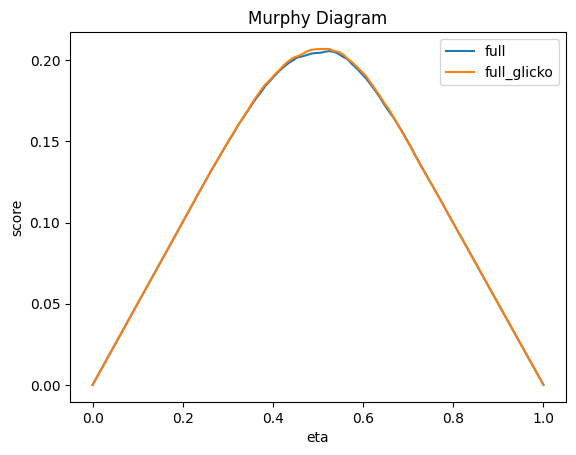

In [46]:
from model_diagnostics.scoring import SquaredError, plot_murphy_diagram

ax = plot_murphy_diagram(
    y_obs=y_test,
    y_pred=df_pred_test,
)

In [47]:
from model_diagnostics.scoring import SquaredError, decompose
import polars as pl

df_list = []
for model_name in df_pred_test:
    df = decompose(
        scoring_function=SquaredError(),
        y_obs=y_test,
        y_pred=df_pred_test[model_name],
        # weights=X_test[models[model_name].weight_key + '_weight'],
    )
    df = df.with_columns(pl.lit(model_name).alias("model"))
    df_list.append(df)
pl.concat(df_list)[:, [-1, 0, 1, 2, 3]]

model,miscalibration,discrimination,uncertainty,score
str,f64,f64,f64,f64
"""full""",0.000551,0.012021,0.249998,0.238528
"""full_glicko""",0.000578,0.011325,0.249998,0.23925


In [48]:
import arviz

for model in df_pred_test:
    print(model)
    display(pipelines[model]["model"].data_)
    display(arviz.summary(pipelines[model]["model"].inf_data_))

full


,elo__prob,elo__r1,elo__r2,pc_elo__prob,pc_elo__r1,pc_elo__r2,min_games__player_1_orig,min_games__player_2_orig,min_games__player_1,min_games__player_2,min_games__min_games_player_1,min_games__min_games_player_2,matchup__mup,matchup__character_1,matchup__character_2,matchup__non_mirror,render__match_date,render__win,render__public
50269,0.615661,1589.361115,1507.509918,0.513453,1507.895448,1498.545118,Kvasir,gwwak,Kvasir,gwwak,False,False,midori-zane,midori,zane,1,2014-02-23 08:31:05,0,False
11112,0.230908,1493.789790,1702.805567,0.480887,1496.375579,1509.663193,JonnyD,Niijima-San,JonnyD,Niijima-San,False,False,jaina-vendetta,jaina,vendetta,1,2016-04-03 00:00:00,0,True
109836,0.684207,1634.314251,1500.000000,0.514188,1509.861795,1500.000000,Nemesis-Kanden,luiifer,Nemesis-Kanden,luiifer,False,False,vendetta-gwen,vendetta,gwen,1,2015-06-19 23:46:08,1,False
101456,0.479297,1513.743825,1528.138015,0.497923,1500.522821,1501.966190,Nelom,noshots00,Nelom,noshots00,False,False,zane-zane,zane,zane,0,2015-05-16 18:31:06,0,False
44852,0.518305,1557.968680,1545.243341,0.513341,1508.278856,1499.006339,IamNobody,Rox Robstah,IamNobody,Rox Robstah,False,False,geiger-quince,geiger,quince,1,2013-11-12 21:25:10,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42391,0.374829,1467.647091,1556.513517,0.490676,1494.018760,1500.498567,Request,ox_quiz,Request,ox_quiz,False,False,grave-zane,grave,zane,1,2013-10-12 00:45:10,0,False
21334,0.416980,1565.108236,1623.335472,0.497996,1498.413742,1499.806127,Hobusu,snoc,Hobusu,snoc,False,False,setsuki-gloria,setsuki,gloria,1,2018-10-25 00:00:00,0,True
82422,0.542012,1523.812773,1494.550872,0.489356,1491.612323,1499.009872,Hamvvar,TigerReia,Hamvvar,TigerReia,False,False,grave-valerie,grave,valerie,1,2015-01-31 17:42:18,0,False
13413,0.695593,1660.194047,1516.633435,0.524480,1518.018158,1500.994323,mastrblastr,snoc,mastrblastr,snoc,False,False,argagarg-argagarg,argagarg,argagarg,0,2016-07-30 00:00:00,0,True


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[grave-grave],0.006,0.498,-0.910,0.910,0.006,0.009,7654.0,2902.0,1.0
mu[grave-midori],0.159,0.090,-0.014,0.328,0.001,0.001,6698.0,2667.0,1.0
mu[grave-rook],0.064,0.080,-0.083,0.213,0.001,0.001,6912.0,2659.0,1.0
mu[grave-valerie],0.282,0.083,0.137,0.449,0.001,0.001,6428.0,2391.0,1.0
mu[grave-lum],0.061,0.113,-0.146,0.274,0.001,0.002,7265.0,2481.0,1.0
...,...,...,...,...,...,...,...,...,...
mu[gwen-gwen],-0.002,0.498,-0.909,0.976,0.006,0.010,7291.0,2642.0,1.0
mu[gwen-zane],-0.341,0.090,-0.511,-0.174,0.001,0.001,7845.0,2600.0,1.0
mu[zane-zane],0.000,0.495,-0.964,0.891,0.006,0.009,7462.0,2817.0,1.0
pc_elo_scale,0.851,0.116,0.632,1.068,0.002,0.001,5423.0,3490.0,1.0


full_glicko


,glicko__prob,glicko__r1,glicko__rd1,glicko__v1,glicko__r2,glicko__rd2,glicko__v2,pc_glicko__prob,pc_glicko__r1,pc_glicko__rd1,...,min_games__player_2,min_games__min_games_player_1,min_games__min_games_player_2,matchup__mup,matchup__character_1,matchup__character_2,matchup__non_mirror,render__match_date,render__win,render__public
50269,0.633584,1621.672280,74.891514,0.090101,1521.289602,75.187876,0.090027,0.581947,1542.473577,28.750193,...,gwwak,False,False,midori-zane,midori,zane,1,2014-02-23 08:31:05,0,False
11112,0.232371,1505.232693,77.068239,0.090032,1724.902209,77.154794,0.089732,0.374848,1485.131999,36.927295,...,Niijima-San,False,False,jaina-vendetta,jaina,vendetta,1,2016-04-03 00:00:00,0,True
109836,0.710659,1661.219822,75.622030,0.090106,1500.000000,30.000000,0.090000,0.555360,1539.223275,24.345909,...,luiifer,False,False,vendetta-gwen,vendetta,gwen,1,2015-06-19 23:46:08,1,False
101456,0.480170,1509.411668,45.012267,0.090023,1523.726042,75.626981,0.090358,0.484250,1509.150779,47.752226,...,noshots00,False,False,zane-zane,zane,zane,0,2015-05-16 18:31:06,0,False
44852,0.522043,1561.985284,74.558911,0.089647,1545.825143,74.328144,0.090069,0.617311,1571.741394,38.427095,...,Rox Robstah,False,False,geiger-quince,geiger,quince,1,2013-11-12 21:25:10,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42391,0.340284,1490.092828,75.842949,0.090048,1611.625971,76.394712,0.090066,0.437138,1461.985882,37.380761,...,ox_quiz,False,False,grave-zane,grave,zane,1,2013-10-12 00:45:10,0,False
21334,0.418224,1626.169341,75.641725,0.090205,1686.714447,75.439728,0.090330,0.498624,1499.419573,31.014318,...,snoc,False,False,setsuki-gloria,setsuki,gloria,1,2018-10-25 00:00:00,0,True
82422,0.621498,1583.876535,76.573925,0.090114,1493.290086,68.032012,0.090005,0.460900,1461.656134,29.598836,...,TigerReia,False,False,grave-valerie,grave,valerie,1,2015-01-31 17:42:18,0,False
13413,0.673663,1675.826417,75.704413,0.089226,1542.935902,74.710253,0.090070,0.599802,1584.477791,28.071728,...,snoc,False,False,argagarg-argagarg,argagarg,argagarg,0,2016-07-30 00:00:00,0,True


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[grave-grave],0.003,0.515,-0.903,1.018,0.005,0.011,9295.0,2146.0,1.0
mu[grave-midori],0.162,0.090,-0.014,0.325,0.001,0.001,12138.0,2880.0,1.0
mu[grave-rook],0.042,0.084,-0.121,0.192,0.001,0.002,10282.0,2504.0,1.0
mu[grave-valerie],0.270,0.084,0.106,0.422,0.001,0.001,12012.0,3035.0,1.0
mu[grave-lum],0.074,0.115,-0.132,0.308,0.001,0.002,8478.0,2423.0,1.0
...,...,...,...,...,...,...,...,...,...
mu[gwen-gwen],0.005,0.505,-0.916,0.987,0.005,0.010,12031.0,2457.0,1.0
mu[gwen-zane],-0.316,0.094,-0.488,-0.144,0.001,0.001,12688.0,2532.0,1.0
mu[zane-zane],-0.010,0.505,-0.961,0.951,0.004,0.010,12941.0,2624.0,1.0
pc_glicko_scale,0.466,0.033,0.407,0.532,0.000,0.000,7348.0,3352.0,1.0


# Parameter Search

In [ ]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV, HalvingGridSearchCV
from scipy.stats import loguniform, uniform
from sklearn.model_selection import GridSearchCV
initial_values = [(1500., rd, v) for rd in [200, 350, 500] for v in [0.03, 0.06, 0.1]]
pc_init_values = [(1500., rd, v) for rd in [200, 350, 500] for v in [0.003, 0.007, 0.01]]
search = HalvingGridSearchCV(
    pipelines['full_glicko'],
    {
        'transform__glicko__initial_value': initial_values,
        'transform__pc_glicko__initial_value': initial_values,
    },
    scoring='neg_brier_score',
    verbose=2,
    min_resources='exhaust')
search.fit(X_train, y_train)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 1113
max_resources_: 90229
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 81
n_resources: 1113
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Compiling...
Compilation time =  0:00:01.608925
Sampling...
Sampling time =  0:00:06.845743
Transforming variables...
Transformation time =  0:00:00.894993
[CV] END transform__glicko__initial_value=(1500.0, 200, 0.03), transform__pc_glicko__initial_value=(1500.0, 200, 0.03); total time=  10.1s
Compiling...
Compilation time =  0:00:01.518841
Sampling...
Sampling time =  0:00:05.678955
Transforming variables...
Transformation time =  0:00:00.884189
[CV] END transform__glicko__initial_value=(1500.0, 200, 0.03), transform__pc_glicko__initial_value=(1500.0, 200, 0.03); total time=   8.7s
Compiling...
Compilation time =  0:00:01.531118
Sampling...
Sampling time =  0:00:05.762210
Transforming variables...
Transformation time =  0:00

# Cross Validation

In [ ]:
import arviz
arviz.plot_pair(models['full'].inf_data_, var_names=['pc_elo_sum_intercept', 'elo_sum_intercept']

In [ ]:
scores = cross_validate(
    pipelines['full_glicko'],
    X_train,
    y=y_train,
    # fit_params={'sample_weights': hist_games.weight},
    cv=5,
    scoring=(
        "neg_brier_score",
        "neg_log_loss",
        "roc_auc",
        "precision",
        "recall",
        "f1",
    ),
)
pandas.DataFrame(scores).describe()

In [ ]:
scores = cross_validate(
    elo_only,
    hist_games,
    y=hist_games.win,
    cv=5,
    scoring=(
        "neg_brier_score",
        "neg_log_loss",
        "roc_auc",
        "precision",
        "recall",
        "f1",
    ),
)
pandas.DataFrame(scores).describe()

In [ ]:
scores = cross_validate(
    full,
    hist_games,
    y=hist_games.win,
    fit_params={'sample_weights': hist_games.weight},
    cv=5,
    scoring=(
        "neg_brier_score",
        "neg_log_loss",
        "roc_auc",
        "precision",
        "recall",
        "f1",
    ),
)
pandas.DataFrame(scores).describe()

In [ ]:
scores = cross_validate(
    full,
    hist_games,
    y=hist_games.win,
    fit_params={'sample_weights': hist_games.weight},
    cv=5,
    scoring=(
        "neg_brier_score",
        "neg_log_loss", 
        "roc_auc",
        "precision",
        "recall",
        "f1",
    ),
)
pandas.DataFrame(scores).describe()